In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from typing import OrderedDict
from torch.utils.data import DataLoader, TensorDataset, Subset, SubsetRandomSampler
import torchvision
from torchvision import transforms

# setup
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_FOLD = 5

print(DEVICE)
print(torch.cuda.device_count())

cuda
1


In [2]:
# # compute accuracy
# def get_accuracy(logit, target, batch_size):
#     ''' Obtain accuracy for training round '''
#     _, predicted = torch.max(logit, 1)
#     corrects = (predicted == target).sum().item()
#     accuracy = 100.0 * corrects/batch_size
#     print(corrects, target.shape)
#     return accuracy

class ModelTrainer:

    def __init__(self,
                 model,
                 train_dataset,
                 test_dataset,
                 epochs,
                 optimizer,
                 print_frequency):
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.model = model
        self.epochs = epochs
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = optimizer
        self.print_frequency = print_frequency

        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def learn(self):
        self.train_corrects = 0;
        self.model = self.model.to(DEVICE)

        # training with full dataset
        self.best_train_loss = 1e+15
        self.best_val_loss = 1e+15
        train_loader = DataLoader(dataset=self.train_dataset,
                          batch_size=512,
                          shuffle=True,
                          num_workers=8)
        for epoch in range(self.epochs):
            # training
            print(f"Training for epoch: {epoch}")
            train_loss, train_accuracy = self.train(self.model, train_loader)
            
            # # cross-validation
            val_loss, val_accuracy = self.cross_validate()

            # for plotting
            if (epoch != 0):
                self.train_losses.append(train_loss)
                self.val_losses.append(val_loss)
                self.train_accuracies.append(train_accuracy)
                self.val_accuracies.append(val_accuracy)
                
            # keep best model --> model w/ lowest cross validation loss so far
            if (val_loss < self.best_val_loss):
                self.best_val_loss = val_loss
                self.best_train_loss = train_loss
                self.best_val_accuracy = val_accuracy
                self.best_train_accuracy = train_accuracy
                self.best_model = copy.deepcopy(self.model)

            # print everything
            if (epoch % self.print_frequency == 0):
                print("Epoch: %d | Train loss: %.4f | Train accuracy: %.2f | Val loss: %.4f | Val accuracy: %.2f" \
                     % (epoch, train_loss, train_accuracy, val_loss, val_accuracy))

        print(f"Best model based on cross validation:\nCross validation loss: %.4f\nCross validation accuracy: %.2f" \
          % (self.best_val_loss, self.best_val_accuracy))
    
        test_loader = DataLoader(dataset=self.test_dataset, batch_size=128)
        test_loss, test_accuracy = self.test(self.best_model, test_loader)
        print("Test accuracy: %.2f" % test_accuracy)
        
        self.plot()

    def train(self, model, train_loader):
        model.train()
        total_loss = 0
        total_correct = 0
        for i, (train_batch, target) in enumerate(train_loader):
            # print(f"\tBatch {i} size {len(train_batch)}")
            train_batch = train_batch.to(DEVICE)
            target = target.to(DEVICE)
            
            self.optimizer.zero_grad()
            outputs = model(train_batch)
            loss = self.loss_fn(outputs, target)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == target).sum().item()
        accuracy = 100 * total_correct / len(train_loader.dataset)
        return total_loss, accuracy

    def test(self, model, test_loader):
        model.eval()
        total_loss = 0
        total_correct = 0
        with torch.no_grad():
            for i, (test_batch, target) in enumerate(test_loader):
                test_batch = test_batch.to(DEVICE)
                target = target.to(DEVICE)
                
                outputs = model(test_batch)
                loss = self.loss_fn(outputs, target)
                total_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total_correct += (predicted == target).sum().item()
        accuracy = 100 * total_correct / len(test_loader.dataset)
        return total_loss, accuracy

    def cross_validate(self):
        kfold = KFold(n_splits=NUM_FOLD, shuffle=True)
        all_losses = 0
        all_accuracy = 0

        for i, (train_idx, val_idx) in enumerate(kfold.split(self.train_dataset)):
            # duplicate original model for validation in this fold
            validation_model = copy.deepcopy(self.model)

            # create training dataset
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
            train_loader = DataLoader(self.train_dataset,
                                      batch_size=256,
                                      sampler=train_subsampler)

            # create validation dataset
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
            val_loader = DataLoader(self.train_dataset,
                                    batch_size=256,
                                    sampler=val_subsampler)

            # train and test
            self.train(validation_model, train_loader)
            fold_losses, fold_accuracy = self.test(validation_model, val_loader)

            # add fold losses accumulator
            all_losses += fold_losses
            all_accuracy += fold_accuracy
        
        # calculate overall losses
        avg_losses = all_losses
        avg_accuracy = all_accuracy
        return avg_losses, avg_accuracy

    def plot(self):
        ep = list(range(0,self.epochs-1))

        plt.figure(figsize=(12,3))
        plt.subplot(131)
        plt.plot(ep, self.train_losses)
        plt.ylabel('Train Loss')
        plt.xlabel('Epoch')
        plt.subplot(132)
        plt.plot(ep, self.val_losses)
        plt.ylabel('Val Loss')
        plt.xlabel('Epoch')

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # 1. Complete layer definition for a 2-layer CNN
        self.layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=32,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=32,
                      out_channels=32,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
      
        self.fc = nn.Linear(in_features=32*64*64, out_features=2)

    def forward(self, x):
        # 2. Complete network architecture definition
        out = self.layer_1(x)
        out = self.layer_2(out)
        out = out.reshape(out.shape[0], -1) # reshape to batch size x linear input
        logits = self.fc(out)
        
        return logits

In [ ]:
# trans = transforms.ToTensor()
# fmnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
# fmnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)

In [4]:
from dataset import get_datasets

train_dataset, test_dataset = get_datasets()
# img, label = train_dataset[0]
# len(train_dataset), img.shape, label
train_dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0000]],
 
         [[0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ...,

Training for epoch: 0
Epoch: 0 | Train loss: 44.4601 | Train accuracy: 64.85 | Val loss: 660.9915 | Val accuracy: 57.91
Training for epoch: 1
Epoch: 1 | Train loss: 40.0431 | Train accuracy: 67.78 | Val loss: 81.6834 | Val accuracy: 67.61
Training for epoch: 2
Epoch: 2 | Train loss: 24.9950 | Train accuracy: 79.68 | Val loss: 41.3170 | Val accuracy: 83.91
Training for epoch: 3
Epoch: 3 | Train loss: 17.4798 | Train accuracy: 87.29 | Val loss: 1143.1303 | Val accuracy: 61.19
Training for epoch: 4
Epoch: 4 | Train loss: 32.7843 | Train accuracy: 86.33 | Val loss: 32.1898 | Val accuracy: 89.75
Training for epoch: 5
Epoch: 5 | Train loss: 12.8059 | Train accuracy: 92.37 | Val loss: 67.4003 | Val accuracy: 84.03
Training for epoch: 6
Epoch: 6 | Train loss: 14.1462 | Train accuracy: 91.58 | Val loss: 43.5465 | Val accuracy: 87.59
Training for epoch: 7
Epoch: 7 | Train loss: 13.3991 | Train accuracy: 91.60 | Val loss: 63.9325 | Val accuracy: 79.14
Training for epoch: 8
Epoch: 8 | Train loss: 

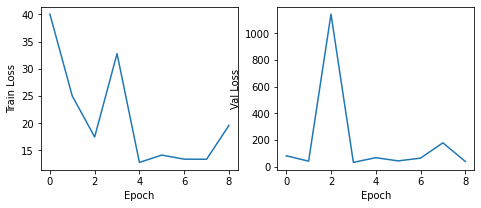

In [5]:
model = CNN()

learning_rate = 0.001
num_epochs = 10

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # optimizer
model_trainer = ModelTrainer(model, train_dataset, test_dataset, num_epochs, optimizer, 1)
model_trainer.learn()